In [1]:
import torch
from src.module2graph import GraphInterperterWithGamma
from src.resnet18 import ResNet18
import numpy as np

import graphviz


In [2]:
resnet = ResNet18()
warp = GraphInterperterWithGamma(resnet)

Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


In [3]:
named_dict = dict(resnet.named_modules())

for node in warp.graph.nodes:
    if node.op == 'call_module':
        pass
        # print('Norm', np.sqrt(sum([(p ** 2).sum().item() \
        #                            for p in named_dict[node.target].parameters()])))
    # print(node.op, node.name, node.args)
    # break
    

In [4]:
def module_to_graph(m: torch.nn.Module):
    warp = GraphInterperterWithGamma(m)
    named_dict = dict(m.named_modules())
    edges = [] # (from, to)
    weights = {'x': 0} # node: params
    for node in warp.graph.nodes:
        # no placeholder and call_mathod
        if node.op == 'call_module':
            n_params = sum([p.numel() for p in named_dict[node.target].parameters()])
            weights[node.name] = n_params
            assert len(node.args) == 1
            for arg in node.args:
                if type(arg) == torch.fx.Node:  # ignore constants
                    edges.append((arg.name, node.name))
        elif node.op == 'call_function':
            for arg in node.args:
                if type(arg) == torch.fx.Node:  # ignore constants
                    edges.append((arg.name, node.name))
            weights[node.name] = 0
        elif node.op == 'output':
            edges.append((node.args[0][0].name, node.name))
            weights['output'] = 0
            
    return edges, {'_'.join(k.split('.')): v for k, v in weights.items()}
    

In [5]:
edges, weights = module_to_graph(ResNet18())
# edges, weights
edges[:10], list(weights.items())[:10]

Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


([('x', 'model_conv1'),
  ('model_conv1', 'model_bn1'),
  ('model_bn1', 'model_relu'),
  ('model_relu', 'model_maxpool'),
  ('model_maxpool', 'model_layer1_0_conv1'),
  ('model_layer1_0_conv1', 'model_layer1_0_bn1'),
  ('model_layer1_0_bn1', 'model_layer1_0_relu'),
  ('model_layer1_0_relu', 'model_layer1_0_conv2'),
  ('model_layer1_0_conv2', 'model_layer1_0_bn2'),
  ('model_layer1_0_bn2', 'add')],
 [('x', 0),
  ('model_conv1', 9408),
  ('model_bn1', 128),
  ('model_relu', 0),
  ('model_maxpool', 0),
  ('model_layer1_0_conv1', 36864),
  ('model_layer1_0_bn1', 128),
  ('model_layer1_0_relu', 0),
  ('model_layer1_0_conv2', 36864),
  ('model_layer1_0_bn2', 128)])

In [6]:
g = graphviz.Digraph('G', filename='hello.gv')

for src, dst in edges:
    g.edge(src, dst)

# g

In [7]:
# TODO: magnitude/Molchanov
edges_importance = [1] * len(edges)

### Pseudocode

1. Consider the vertex that is one of the a childs of the built graph. Try to put it into each leayer where possible, minimizing the loss (the total weight of pruned edges). Note that the ansestors must be in the current or the previous layer. Also consider the case when the vertex is isolated, i.e. we create a new layer.

2. Repeat (1) until there exist vertices



In [8]:
def get_subgraph(edges, weights, e_importance, memory=1e10):
    # build a graph matrix
    node_ids = {k: i for i, k in enumerate(weights)}
    id_to_node = [node for _, node in enumerate(weights)]
    m = np.zeros((len(node_ids), len(node_ids))).astype(np.int32)
    assert len(edges) == len(e_importance)
    for (src, dst), w in zip(edges, e_importance):
        src_id, dst_id = node_ids[src], node_ids[dst]
        m[src_id, dst_id] = w
    
    node_to_layer = [-100] * len(node_ids)
    layer_to_memory = [0]
    node_to_layer[node_ids['x']] = 0
    cur_layer = 0
    for _ in range(m.shape[0]):
        for node_id in range(m.shape[0]):  # node from the current layer
            if node_to_layer[node_id] != cur_layer:
                continue
            best_id, best_overflow_id = -1, -1
            best_value, best_overflow_value = 1e9, 1e9
            for to in range(m.shape[0]):  # candidate to be put
                if m[node_id, to] == 0 or node_to_layer[to] != -100:
                    continue
                is_overflow = weights[id_to_node[to]] + layer_to_memory[cur_layer] > memory
                # try to add it to the current layer (TODO: try adding to all layers, which seems to be irrelevant)
                pruned_value = sum([m[j, to] for j in range(m.shape[0]) \
                                    if m[j, to] != 0 and (node_to_layer[j] < cur_layer - 1 or node_to_layer[j] > cur_layer)])
                if is_overflow:
                    if pruned_value < best_overflow_value:
                        best_overflow_value = pruned_value
                        best_overflow_id = to
                else:
                    if pruned_value < best_value:
                        best_value = pruned_value
                        best_id = to
            if best_id != -1:
                assert node_to_layer[best_id] == -100
                node_to_layer[best_id] = cur_layer
                layer_to_memory[cur_layer] += weights[id_to_node[best_id]]
            elif best_id == -1 and best_overflow_id != -1:  # overflow
                cur_layer += 1
                node_to_layer[best_overflow_id] = cur_layer
                layer_to_memory.append(weights[id_to_node[best_overflow_id]])
    
    # TODO: finally, prune the edges given a layer for each node
    return {'layers': {id_to_node[i]: l for i, l in enumerate(node_to_layer)}, 'm': m}
    

get_subgraph(edges, {k: 1 for k in weights}, edges_importance, 5)['layers']

{'x': 0,
 'model_conv1': 0,
 'model_bn1': 0,
 'model_relu': 0,
 'model_maxpool': 0,
 'model_layer1_0_conv1': 0,
 'model_layer1_0_bn1': 1,
 'model_layer1_0_relu': 1,
 'model_layer1_0_conv2': 1,
 'model_layer1_0_bn2': 1,
 'add': 1,
 'model_layer1_0_relu_1': 2,
 'model_layer1_1_conv1': 2,
 'model_layer1_1_bn1': 2,
 'model_layer1_1_relu': 2,
 'model_layer1_1_conv2': 2,
 'model_layer1_1_bn2': 3,
 'add_1': 3,
 'model_layer1_1_relu_1': 3,
 'model_layer2_0_conv1': 3,
 'model_layer2_0_bn1': 3,
 'model_layer2_0_relu': 4,
 'model_layer2_0_conv2': 4,
 'model_layer2_0_bn2': 4,
 'model_layer2_0_downsample_0': -100,
 'model_layer2_0_downsample_1': -100,
 'add_2': 4,
 'model_layer2_0_relu_1': 4,
 'model_layer2_1_conv1': 5,
 'model_layer2_1_bn1': 5,
 'model_layer2_1_relu': 5,
 'model_layer2_1_conv2': 5,
 'model_layer2_1_bn2': 5,
 'add_3': 6,
 'model_layer2_1_relu_1': 6,
 'model_layer3_0_conv1': 6,
 'model_layer3_0_bn1': 6,
 'model_layer3_0_relu': 6,
 'model_layer3_0_conv2': 7,
 'model_layer3_0_bn2': 7,

## Synthetic Unet-like test

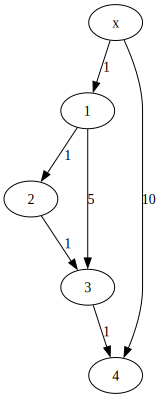

In [9]:
g = graphviz.Digraph('G', filename='hello.gv')

edges = [('x', '1'), ('1', '2'), ('2', '3'), ('3', '4'), \
         ('x', '4'), ('1', '3')]

weights = {str(n) if n > 0 else 'x': 1 for n in range(5)}
edges_importance = [1] * 6
edges_importance[-2] = 10
edges_importance[-1] = 5

for (src, dst), w in zip(edges, edges_importance):
    g.edge(src, dst, label=str(w))

g

In [11]:
get_subgraph(edges, weights, edges_importance, 3)['layers']
# optimal [x: 0, (123): 1, 4: 2]

{'x': 0, '1': 0, '2': 0, '3': 0, '4': 1}

### Conclusion

It seems that the problem is NP-hard. We need to come up with a new approach.
